In [1]:
import torch
import numpy as np
import pandas as pd
import os
import h5py
from exabiome.nn.loader import read_dataset, LazySeqDataset
import argparse
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from model import *
from data import *
from fastai.text.all import *

In [2]:
hparams = argparse.Namespace(**{'load': False,
                                'window': 4096,
                                'step': 4096,
                                'classify': True,
                                'tgt_tax_lvl': "phylum",
                                'fwd_only': True})

In [3]:
def get_toy_dl(hparams, batch_size=16):
    path = '/global/homes/a/azaidi/ar122_r202.toy.input.h5'
    chunks = LazySeqDataset(hparams, path=path,
                           keep_open=True)
    ds = taxon_ds(chunks, old_pad_seq)
    return DataLoader(ds, batch_size=batch_size, 
                      shuffle=True)#, drop_last=True)

In [39]:
dl = get_toy_dl(hparams, batch_size=128)
batch = next(iter(dl))
len(dl), batch[0].shape, batch[1].shape

(149, torch.Size([128, 1, 4096]), torch.Size([128]))

In [40]:
def get_model():
    model = nn.Sequential(
        get_base_layer(),
        get_dep_sep(32,16),
        get_inv_res(16, 12),
        get_head_layer(12, 1,
                    lin_out_feats=18))
    return model

In [41]:
model = get_model()

In [42]:
dls = DataLoaders(dl, dl)

As a reminder, we're just playing around here -- a proper validation set should be used and not just the same dataloader as the training set :)

In [8]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss())

Trying to train this model will not work -- out of the box -- this can be confirmed by uncommenting the line below

In [9]:
#learn.fit(1)

We'll need to utilize fast.ai's callback system in order to make sure out training loop includes that dimension reduction with the squeeze function, on our models output -- before it get's fed into our loss function. You can find out more about callbacks here: https://docs.fast.ai/callback.core.html

In [10]:
class compress_cb(Callback):
    def after_pred(self):
        self.learn.pred = self.pred.squeeze(1)

In [20]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(),
               cbs=[compress_cb], metrics=[accuracy])#.to_fp16()

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.02754228748381138)

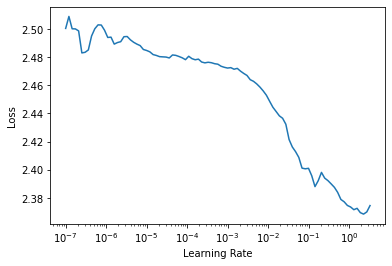

In [18]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(2, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.968522,4.316649,0.311205,06:59
1,1.887349,1.851727,0.393477,06:52


That was super easy! With Fast.AI we can access useful things like the learning rate finder: https://fastai1.fast.ai/callbacks.lr_finder.html: https://arxiv.org/abs/1506.01186

We also get a ton of other useful functionality, like tables for our results + tools to inspect/diagnose how well our model is doing + easy to use techniques to train our model -- for example: <br>
(1) using mixed precision training only requires the ".to_fp16()" as seen in our Learner call<br>
(2) One cycle training is implemented in our fit call above

In [79]:
#gpu is clearly available
#!nvidia-smi

Need to look into why library is having trouble assigning everything to gpu automatically -- perhaps bc using cluster?